In [1]:
from collect_data import *
from torch.utils.data import Dataset, DataLoader

In [2]:
megsp_path = os.path.join(meg_path, 'collect_data/megsp')
audio_path = os.path.join(meg_path, 'collect_data/audio')
megsp_list = os.listdir(megsp_path)
audio_list = os.listdir(audio_path)

megsp_list_session_0 = [f for f in megsp_list if f.split('_')[1] == '0']
megsp_list_session_1 = [f for f in megsp_list if f.split('_')[1] == '1']

In [3]:
def split_tensor(tensor, train_ratio=0.7, val_ratio=0.1):
    total_samples = tensor.size(0)
    train_size = int(total_samples * train_ratio)
    val_size = int(total_samples * val_ratio)
    train_tensor = tensor[:train_size]
    val_tensor = tensor[train_size:train_size + val_size]
    test_tensor = tensor[train_size + val_size:]
    return train_tensor, val_tensor, test_tensor


def get_splitted_tensor(file_list, path):
    tensor_list_train = []
    tensor_list_valid = []
    tensor_list_test = []
    for file_name in file_list:
        file_path = os.path.join(path, file_name)
        tensor = torch.load(file_path)
        train_tensor, val_tensor, test_tensor = split_tensor(tensor)
        tensor_list_train.append(train_tensor)
        tensor_list_valid.append(val_tensor)
        tensor_list_test.append(test_tensor)
    tensor_train = torch.cat(tensor_list_train, dim=0)
    tensor_valid = torch.cat(tensor_list_valid, dim=0)
    tensor_test = torch.cat(tensor_list_test, dim=0)
    return tensor_train, tensor_valid, tensor_test



In [4]:
audio_tensor_train, audio_tensor_valid, audio_tensor_test = get_splitted_tensor(audio_list, audio_path)
audio_tensor_train = torch.cat((audio_tensor_train, audio_tensor_train), 0)
audio_tensor_valid = torch.cat((audio_tensor_valid, audio_tensor_valid), 0)
audio_tensor_test = torch.cat((audio_tensor_test, audio_tensor_test), 0)
print('DIMENSION_AUDIO_TENSOR_TRAIN: ', audio_tensor_train.shape)
print('DIMENSION_AUDIO_TENSOR_VALID: ', audio_tensor_valid.shape)
print('DIMENSION_AUDIO_TENSOR_TEST: ', audio_tensor_test.shape)

meg_0_tensor_train, meg_0_tensor_valid, meg_0_tensor_test = get_splitted_tensor(megsp_list_session_0, megsp_path)
meg_1_tensor_train, meg_1_tensor_valid, meg_1_tensor_test = get_splitted_tensor(megsp_list_session_1, megsp_path)
meg_tensor_train = torch.cat((meg_0_tensor_train, meg_1_tensor_train), 0)
meg_tensor_valid = torch.cat((meg_0_tensor_valid, meg_1_tensor_valid), 0)
meg_tensor_test = torch.cat((meg_0_tensor_test, meg_1_tensor_test), 0)
print('DIMENSION_MEG_TENSOR_TRAIN: ', meg_tensor_train.shape)
print('DIMENSION_MEG_TENSOR_VALID: ', meg_tensor_valid.shape)
print('DIMENSION_MEG_TENSOR_TEST: ', meg_tensor_test.shape)


DIMENSION_AUDIO_TENSOR_TRAIN:  torch.Size([11958, 257, 376])
DIMENSION_AUDIO_TENSOR_VALID:  torch.Size([1684, 257, 376])
DIMENSION_AUDIO_TENSOR_TEST:  torch.Size([3480, 257, 376])
DIMENSION_MEG_TENSOR_TRAIN:  torch.Size([11958, 208, 16, 26])
DIMENSION_MEG_TENSOR_VALID:  torch.Size([1684, 208, 16, 26])
DIMENSION_MEG_TENSOR_TEST:  torch.Size([3480, 208, 16, 26])


In [44]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        """
        """
        assert X.size(0) == Y.size(0), "The number of input and output samples must be the same"
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    

train_dataset = CustomDataset(audio_tensor_train, meg_tensor_train)
valid_dataset = CustomDataset(audio_tensor_valid, meg_tensor_valid)
test_dataset = CustomDataset(audio_tensor_test, meg_tensor_test)

# batch_size = 32  # --> da scegliere
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [5]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

X_train = audio_tensor_train.reshape(audio_tensor_train.shape[0], -1)
y_train = meg_tensor_train.reshape(meg_tensor_train.shape[0], -1)
X_test = audio_tensor_test.reshape(audio_tensor_test.shape[0], -1)
y_test = meg_tensor_test.reshape(meg_tensor_test.shape[0], -1)
X_valid = audio_tensor_valid.reshape(audio_tensor_valid.shape[0], -1)
y_valid = meg_tensor_valid.reshape(meg_tensor_valid.shape[0], -1)

ridge = Ridge(alpha=5000, max_iter=10000)
ridge.fit(X_train, y_train)

pred_test_latent = ridge.predict(X_test)
train_predicted = ridge.predict(X_train)
val_predicted = ridge.predict(X_valid)

print("rmse", mean_squared_error(y_train, train_predicted))
print("rmse", mean_squared_error(y_valid, val_predicted))
print("rmse", mean_squared_error(y_test, pred_test_latent))


rmse 28.434341306011174
rmse 68.27646497559086
rmse 70.31384085931612


In [7]:
y_test_flat = y_test.reshape(-1)
ridge_predictions_flat = pred_test_latent.reshape(-1)
correlation_matrix = np.corrcoef(y_test_flat, ridge_predictions_flat)
print("Correlation matrix between actual and predicted:")
print(correlation_matrix)

Correlation matrix between actual and predicted:
[[1.         0.50532865]
 [0.50532865 1.        ]]


In [19]:
pred_test_latent_reshape = torch.tensor(pred_test_latent).reshape(-1, 208, 16, 26)

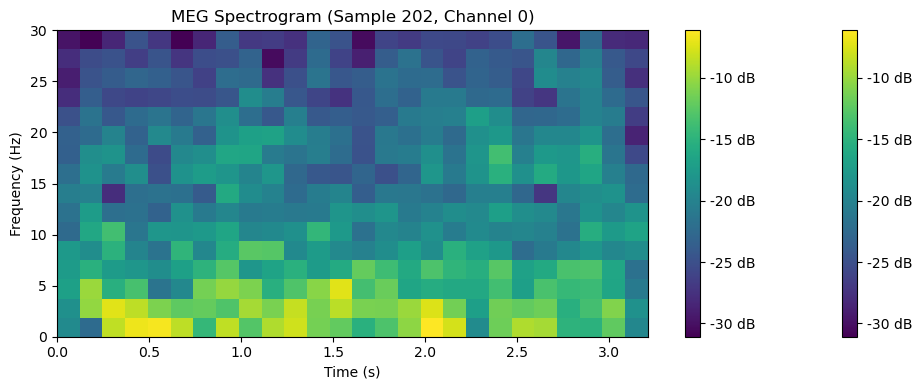

In [41]:
plot_spectrogram(pred_test_latent_reshape, sampling_meg, 202, 0)

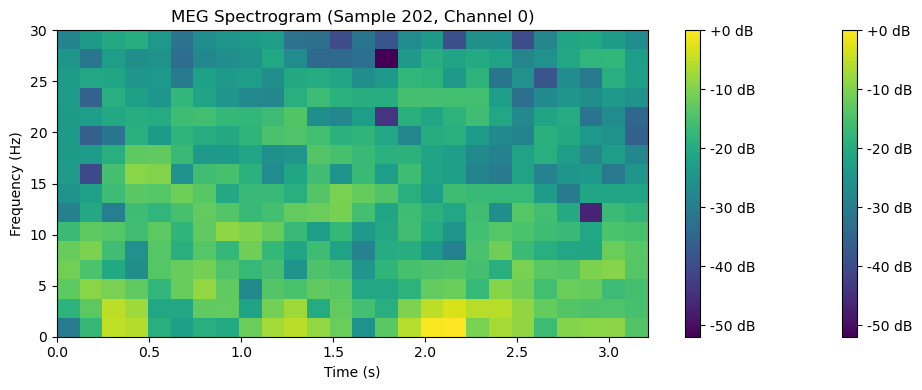

In [42]:
plot_spectrogram(meg_tensor_test, sampling_meg, 202, 0)